In [1]:
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

print('GPU availability status: {}'.format(torch.cuda.is_available()))

GPU availability status: True


In [2]:
if torch.cuda.is_available():
  device ='cuda'

else:
  device='cpu'

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

In [15]:
trainset=torchvision.datasets.FashionMNIST(root='./data',train=True, download=True, transform=data_transforms['train'])
testset=torchvision.datasets.FashionMNIST(root='./data',train=False, download=True, transform=data_transforms['val'])

trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(testset,batch_size=32,shuffle=True,num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

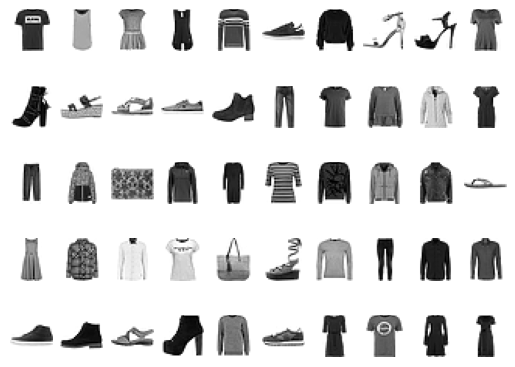

In [16]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

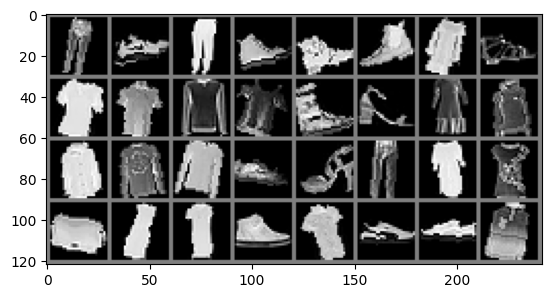

Trouser Sneaker Trouser Sneaker Ankle boot Ankle boot Dress Sandal


In [17]:
def imshow(img):
  img=img/2 + 0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter=iter(trainloader)
images,labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'% classes[labels[j]] for j in range(8)))

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(1,32,3)
    self.conv1_bn=nn.BatchNorm2d(32)
    self.conv2=nn.Conv2d(32,64,3)
    self.conv2_bn=nn.BatchNorm2d(64)
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(64*12*12,128)
    self.fc2=nn.Linear(128,10)
    self.dropOut=nn.Dropout(0.2) #can be given at any layer. best suited after ReLu

  def forward(self,x):
    x=F.relu(self.conv1_bn(self.conv1(x)))
    x=self.dropOut(x)
    x=self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))
    x=self.pool(x)
    x=x.view(-1,64*12*12)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    return x

net=Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [24]:
#weight_decay is used for the L2 regularization. Good values range from 0.1 to 0.0001
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9,weight_decay=0.001)

In [31]:
epochs=15

epoch_log=[]
accuracy_log=[]
loss_log=[]

for epoch in range(epochs):
  print(f'Epoch Number: {epoch+1}')
  running_loss=0.0

  for i,data in enumerate(trainloader,0):
    input,labels=data
    input=input.to(device)
    labels=labels.to(device)

    optimizer.zero_grad()

    outputs=net(input)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()

    if i%100==99:
      total=0
      correct=0
      with torch.no_grad():
        for data in testloader:
          images,labels=data
          images=images.to(device)
          labels=labels.to(device)

          outputs=net(images)

          _,predictions=torch.max(outputs.data,1)
          total+=labels.size(0)
          correct+=(predictions==labels).sum().item()
      
        accuracy=100*correct/total
        epoch_num=epoch+1
        actual_loss=running_loss/50
        print(f'Epoch {epoch_num} :::: Mini Batch {(i+1)} ::::: Loss {actual_loss:.3f} :::: Validation Accuracy {accuracy:.3f}')
        running_loss=0.0

  epoch_log.append(epoch_num)
  loss_log.append(actual_loss)
  accuracy_log.append(accuracy)



print('Training Completed Successfully')

Epoch Number: 1
Epoch 1 :::: Mini Batch 100 ::::: Loss 1.153 :::: Validation Accuracy 78.910
Epoch 1 :::: Mini Batch 200 ::::: Loss 1.149 :::: Validation Accuracy 79.160
Epoch 1 :::: Mini Batch 300 ::::: Loss 1.135 :::: Validation Accuracy 81.430
Epoch 1 :::: Mini Batch 400 ::::: Loss 1.091 :::: Validation Accuracy 82.500
Epoch 1 :::: Mini Batch 500 ::::: Loss 1.078 :::: Validation Accuracy 82.230
Epoch 1 :::: Mini Batch 600 ::::: Loss 1.060 :::: Validation Accuracy 82.700
Epoch 1 :::: Mini Batch 700 ::::: Loss 1.085 :::: Validation Accuracy 83.060
Epoch 1 :::: Mini Batch 800 ::::: Loss 1.061 :::: Validation Accuracy 82.560
Epoch 1 :::: Mini Batch 900 ::::: Loss 1.037 :::: Validation Accuracy 80.910
Epoch 1 :::: Mini Batch 1000 ::::: Loss 1.038 :::: Validation Accuracy 83.950
Epoch 1 :::: Mini Batch 1100 ::::: Loss 1.066 :::: Validation Accuracy 81.900
Epoch 1 :::: Mini Batch 1200 ::::: Loss 0.996 :::: Validation Accuracy 83.570
Epoch 1 :::: Mini Batch 1300 ::::: Loss 0.968 :::: Valida

In [34]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')


Accuracy of the network on the 10000 test images: 89.78%


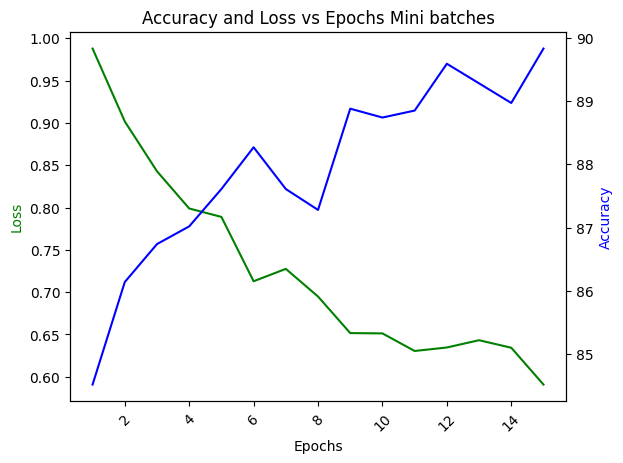

In [35]:
import matplotlib.pyplot as plt

fig,ax1 = plt.subplots()

plt.title('Accuracy and Loss vs Epochs Mini batches')
plt.xticks(rotation=45)

ax2=ax1.twinx()

ax1.plot(epoch_log,loss_log,'g-')
ax2.plot(epoch_log,accuracy_log,'b-')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss",color='g')
ax2.set_ylabel("Accuracy",color='b')

plt.show()